# SI 630: Homework 1: Classification

Name on Kaggle: ccmilne

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from collections import Counter
import random

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dev = pd.read_csv('dev.csv')

In [2]:
train['labels'] = np.where(train['party_affiliation'].str.contains("Democratic Party"), 1, 0)
dev['labels'] = np.where(dev['party_affiliation'].str.contains("Democratic Party"), 1, 0)

In [3]:
print(len(train))
print(len(test))
print(len(dev))

59999
20000
20000


In [4]:
test

,email_text,uid_email
0,"20,000 <GPE> <GPE> signatures needed \n 20,000...",5dfbe09ce5b500dd3dcb9f93c8fb185f
1,We 've worked way too hard and given way too m...,07e48f4183b98420a18503791fb412f6
2,If you use your 800%-MATCH \n <> \n <ORG> <OR...,b58c8607d96a414db0e9cc10108c35f5
3,"<PERSON>, a proposal for Vote- by- <> threaten...",3901d9539d69ada89e5c82e2f1ca950d
4,The <ORG> <ORG> <ORG> is under immediate threa...,6a3e8e6f31381e84a34571deee0f1238
...,...,...
19995,View this email in your browser \n View this ...,9b11afd6a84d3806034d9080f4e9752a
19996,There are few things nearly every <NORP> can a...,888cacc2d660bf040f04ef1caf6ce844
19997,FIGHT for the truth by making 1000 % MORE of a...,712dc83f7a455870373c7a9eb30445d7
19998,"I do n't need six- figure checks, but I do nee...",0bf3265244c2c06fff084c5a79a6387c


## Part 1: Text Data

### 1.1: Tokenization

In [5]:
s = 'Before we can start classifying, we need to turn our text data into some numeric representation that classifiers can work with. In class, we talked about using a bag of words representation—i.e., each document is represented as a vector.'

In [6]:
def tokenize(string):
    return string.split()

In [7]:
# tokenize(s)

In [8]:
# stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
# spacy_terms = ['person', 'norp', 'org', 'gpe']
# stopwords = stop_words + spacy_terms
# [w for w in tokens if not w in stopwords]

In [9]:
import re

def better_tokenize(string):
    pattern = r"\w+\w"
    return re.findall(pattern, string.lower())

In [10]:
# better_tokenize(s)

### 1.2: Building the Term-Document Matrix

This section uses four functions to build the term-document matrices for each data set. They include:

- term_frequency()
- build_docs()
- create_vocab()
- create_matrix()

In [11]:
# import sparse module from SciPy package 
from scipy import sparse

In [12]:
def term_frequency(df, minimum_word_frequency=10):
    emails = list(df['email_text'])
    
    #Build Term Frequency Dictionary
    cnt = Counter()
    for email in tqdm(emails):
        tokens = better_tokenize(email)
        for t in tokens:
            cnt[t] += 1

    #Remove rare words
    minimum_word_frequency = 10
    only_common = Counter({k: v for k, v in cnt.items() if v >= minimum_word_frequency})
    
    return only_common

In [13]:
def build_docs(df, term_freq):
    emails = list(df['email_text'])
    
    docs = {}
    counter = 1
    
    for email in tqdm(emails):
        tokens = better_tokenize(email)    
        for t in tokens:
            if t not in term_freq.keys(): tokens.remove(t)
        docs[counter] = tokens
        counter += 1

    return docs

In [14]:
def create_vocab(docs):
    n_nonzero = 0 #number of nonzero values in the matrix
    vocab = set()

    for docterms in docs.values():
        unique_terms = set(docterms)    # all unique terms of this doc
        vocab |= unique_terms           # set union: add unique terms of this doc
        n_nonzero += len(unique_terms)  # add count of unique terms in this doc

    docnames = np.array(list(docs.keys()))
    vocab = np.array(list(vocab))
    vocab_sorter = np.argsort(vocab)

    ndocs = len(docnames) #Matrix rows
    nvocab = len(vocab) #Matrix columns

    data = np.empty(n_nonzero, dtype=np.intc)
    rows = np.empty(n_nonzero, dtype=np.intc)
    cols = np.empty(n_nonzero, dtype=np.intc)
        
    return vocab, vocab_sorter, data, rows, cols, ndocs, nvocab

In [15]:
def create_matrix(docs, vocab, vocab_sorter, data, rows, cols, ndocs, nvocab):
    current_index = 0
    
    docnames = np.arange(1, len(docs) + 1)

    for docname, terms in tqdm(docs.items()):
#         term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]
        try:
            term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]
        except:
            print("Error with doc:")
            print(docname)
            
        uniq_indices, counts = np.unique(term_indices, return_counts=True)
        n_vals = len(uniq_indices)
        ind_end = current_index + n_vals

        data[current_index:ind_end] = counts
        cols[current_index:ind_end] = uniq_indices
        doc_idx = np.where(docnames == docname)
        rows[current_index:ind_end] = np.repeat(doc_idx, n_vals)

        current_index = ind_end
    
    return sparse.csr_matrix((data, (rows, cols)), shape=(ndocs, nvocab), dtype=np.intc)

Training Data

In [16]:
term_freq_train = term_frequency(df=train)
docs_train = build_docs(train, term_freq_train)

vocab, vocab_sorter, data, rows, cols, ndocs, nvocab = create_vocab(docs_train)

sparse_matrix_train = create_matrix(docs_train, vocab, vocab_sorter, data, rows, cols, ndocs, nvocab)

100%|██████████| 59999/59999 [00:27<00:00, 2158.68it/s]


In [17]:
sparse_matrix_train

<59999x15389 sparse matrix of type '<class 'numpy.intc'>'
	with 9891710 stored elements in Compressed Sparse Row format>

Development/Validation Data

In [18]:
term_freq_dev = term_frequency(df=dev)
docs_dev = build_docs(dev, term_freq_dev)

vocab_dev, vocab_sorter_dev, data_dev, rows_dev, cols_dev, ndocs_dev, nvocab_dev = create_vocab(docs_dev)

100%|██████████| 20000/20000 [00:06<00:00, 2918.73it/s]


In [19]:
ndocs_dev = len(docs_dev)

sparse_matrix_dev = create_matrix(docs_dev, vocab, vocab_sorter, data_dev, rows_dev, cols_dev, ndocs_dev, nvocab)

100%|██████████| 20000/20000 [00:07<00:00, 2614.17it/s]


In [20]:
sparse_matrix_dev

<20000x15389 sparse matrix of type '<class 'numpy.intc'>'
	with 3276016 stored elements in Compressed Sparse Row format>

Testing Data

In [21]:
term_freq_test = term_frequency(df=test)
docs_test = build_docs(test, term_freq_test)

vocab_test, vocab_sorter_test, data_test, rows_test, cols_test, ndocs_test, nvocab_test = create_vocab(docs_test)

100%|██████████| 20000/20000 [01:08<00:00, 291.46it/s] 


In [22]:
ndocs_test = len(docs_test)

sparse_matrix_test = create_matrix(docs_test, vocab, vocab_sorter, data_test, rows_test, cols_test, ndocs_test, nvocab)

 57%|█████▋    | 11465/20000 [00:04<00:03, 2628.51it/s]

Error with doc:
11108


100%|██████████| 20000/20000 [00:08<00:00, 2471.51it/s]


In [23]:
sparse_matrix_test

<20000x15389 sparse matrix of type '<class 'numpy.intc'>'
	with 3271395 stored elements in Compressed Sparse Row format>

## Part 2: Logistic Regression in numpy

In [24]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

In [25]:
def log_likelihood(b, X, y):
    '''
    Calculates the log likelihood (aka maximum likelihood) 
    of the training data given Beta parameters    
    '''
    return np.dot(y, X*b) - np.log(1 + np.exp(X*b)).sum()

In [26]:
def compute_gradient(b, X, y):
    return X * (sigmoid(np.dot(b, X)) - y)

In [27]:
def logistic_regression(X, y, learning_rate, num_steps):
    '''
    Logistic regression function that takes in:
    
    – a matrix X where each row is a vector that has the features for that instance
    – a vector Y containing the class of the row
    – learning rate which is a parameter to control how much you change the β values each step
    – num step how many steps to update β before stopping
    
    '''
    ### Initialize parameters (betas)
#     betas = (np.random.random(X.shape[1]) - 0.5) / 100
    betas = np.zeros(X.shape[1])    
    
    lls = []
    
    idx = 0
    
    for i in range(num_steps):
        betas -= learning_rate * compute_gradient(b=betas, X=X[idx].toarray()[0], y=y[idx])
        
        ### Compute log likelihood to observe the loss rate (for graphing purposes)
        if i % 100 == 100 - 1: #any time the remainder of i-100=99: 
            ll = log_likelihood(b=betas, X=X, y=y)
            lls.append(ll)
            print(f"Turn {i + 1}: ll: {ll}")
        
#         idx += 1
        idx = (idx + 1) % X.shape[0]
    
    return (betas, lls)

Training Data and Log-Likelihood Mapping

In [28]:
X = sparse_matrix_train
y = list(train['labels'])

model = logistic_regression(X, y, learning_rate=1e-5, num_steps=1000)

Turn 100: ll: -35703.508718314646
Turn 200: ll: -33736.60604505231
Turn 300: ll: -32211.09688165535
Turn 400: ll: -31455.44974741259
Turn 500: ll: -30979.55760565806
Turn 600: ll: -30625.516861198033
Turn 700: ll: -30138.87604433771
Turn 800: ll: -29988.445064203952
Turn 900: ll: -29936.203300699934
Turn 1000: ll: -29839.31606744811


In [29]:
betas = model[0]
betas

array([0.00000000e+00, 8.67293249e-06, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [30]:
lls = model[1]

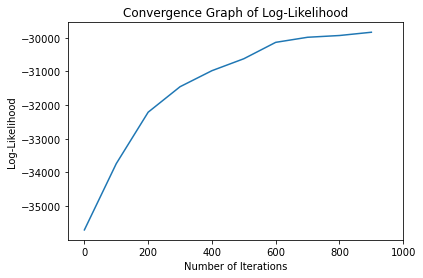

In [31]:
import matplotlib.pyplot as plt

lls = model[1]

x_axis = np.arange(0, 1000, 100)

plt.figure()
plt.plot(x_axis, lls)
plt.title("Convergence Graph of Log-Likelihood")
plt.xlim(-50, 1000)
plt.xlabel("Number of Iterations")
plt.ylabel("Log-Likelihood")
plt.show()

In [32]:
def predict(b, X, y, threshold=0.5):
    '''   
    Prediction function that takes in:
    
    - betas from training set
    - a vector X from a dev/test set
    - a vector y as the true values
    '''
    iterations = len(y) #X.shape[0]
    
    y_predictions = 0
    idx = 0
    
    for i in tqdm(range(iterations)):
        outcome = np.round(sigmoid(np.dot(X[idx].toarray()[0], b)))
        if outcome == y[idx]:
            y_predictions += 1
        idx += 1
        
#     outcome = np.round(sigmoid(np.dot(X, b))) >= threshold
#     return outcome
    return y_predictions

In [33]:
X = sparse_matrix_dev
y_dev = list(dev['labels'])

In [34]:
y_predictions = predict(betas, X, y_dev)

100%|██████████| 20000/20000 [00:04<00:00, 4203.69it/s]


In [35]:
f1 = y_predictions / len(y_dev)
f1

0.8047

Submission for Kaggle with test data

In [36]:
X = sparse_matrix_train
y = list(train['labels'])

model = logistic_regression(X, y, learning_rate=1e-5, num_steps=10000)
betas = model[0]

Turn 100: ll: -35703.508718314646
Turn 200: ll: -33736.60604505231
Turn 300: ll: -32211.09688165535
Turn 400: ll: -31455.44974741259
Turn 500: ll: -30979.55760565806
Turn 600: ll: -30625.516861198033
Turn 700: ll: -30138.87604433771
Turn 800: ll: -29988.445064203952
Turn 900: ll: -29936.203300699934
Turn 1000: ll: -29839.31606744811
Turn 1100: ll: -29830.962427717903
Turn 1200: ll: -29763.289783843924
Turn 1300: ll: -29773.29587398129
Turn 1400: ll: -29667.931755179423
Turn 1500: ll: -29529.649763264322
Turn 1600: ll: -29472.687704635406
Turn 1700: ll: -29410.72630952341
Turn 1800: ll: -29376.25701289758
Turn 1900: ll: -29291.25626646432
Turn 2000: ll: -29237.174414193214
Turn 2100: ll: -29166.58580461472
Turn 2200: ll: -29112.061106729932
Turn 2300: ll: -29079.392065691165
Turn 2400: ll: -29003.323058343318
Turn 2500: ll: -28960.147029382177
Turn 2600: ll: -28950.72671527654
Turn 2700: ll: -28894.481492140083
Turn 2800: ll: -28792.246458935755
Turn 2900: ll: -28727.823411596117
Turn 3

In [37]:
def predict(b, X, threshold=0.5):
    
    outcomes = []
    idx = 0
    
    for i in tqdm(range(sparse_matrix_test.shape[0])):
        outcome = sigmoid(np.dot(X[idx].toarray()[0], b))
#         print(outcome)

        if outcome > threshold:
            outcomes.append("Democratic Party")
        else:
            outcomes.append("Republican Party")         
        idx += 1
        
    return outcomes

In [38]:
predictions = predict(betas, sparse_matrix_test)

100%|██████████| 20000/20000 [00:04<00:00, 4801.22it/s]


In [39]:
np.unique(predictions, return_counts=True)

(array(['Democratic Party', 'Republican Party'], dtype='<U16'),
 array([19987,    13], dtype=int64))

In [40]:
test['party_affiliation'] = predictions
submission_df = test[['uid_email', 'party_affiliation']]
submission_df

,uid_email,party_affiliation
0,5dfbe09ce5b500dd3dcb9f93c8fb185f,Democratic Party
1,07e48f4183b98420a18503791fb412f6,Democratic Party
2,b58c8607d96a414db0e9cc10108c35f5,Democratic Party
3,3901d9539d69ada89e5c82e2f1ca950d,Democratic Party
4,6a3e8e6f31381e84a34571deee0f1238,Democratic Party
...,...,...
19995,9b11afd6a84d3806034d9080f4e9752a,Democratic Party
19996,888cacc2d660bf040f04ef1caf6ce844,Democratic Party
19997,712dc83f7a455870373c7a9eb30445d7,Democratic Party
19998,0bf3265244c2c06fff084c5a79a6387c,Democratic Party


In [41]:
submission_df.to_csv('numpy_logit_submission.csv', index=False)

## Part 3: Logistic Regression with PyTorch

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
def to_sparse_tensor(sparse_matrix):
    X = sparse_matrix.tocoo()
    return torch.sparse_coo_tensor(np.mat([X.row, X.col]), X.data, size = X.shape).to(torch.float)

sparse_tensor_train = to_sparse_tensor(sparse_matrix_train)
sparse_tensor_dev = to_sparse_tensor(sparse_matrix_dev)
sparse_tensor_test = to_sparse_tensor(sparse_matrix_test)

In [44]:
sparse_tensor_train.to(torch.float)
sparse_tensor_dev.to(torch.float)
sparse_tensor_test.to(torch.float)

tensor(indices=tensor([[    0,     0,     0,  ..., 19999, 19999, 19999],
                       [    0,    45,   145,  ..., 14544, 14820, 15145]]),
       values=tensor([0., 2., 1.,  ..., 1., 1., 1.]),
       size=(20000, 15389), nnz=3271395, layout=torch.sparse_coo)

In [45]:
y_train = torch.tensor(list(train['labels']), dtype=torch.float)
y_dev = torch.tensor(list(dev['labels']), dtype=torch.float)
# y_test = torch.tensor(list(test['labels']), dtype=torch.float)

In [46]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim): #input_dim, output_dim
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim) #input_dim, output_dim
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

input_dim = sparse_tensor_train.shape[1] #size of vocabulary
output_dim = 1 #output should always be zero or one

In [47]:
model = LogisticRegression(input_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

Step 1

In [61]:
model = LogisticRegression(input_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

running_loss = 0.0
for step in range(1000):
    i = np.random.randint(1, 20000)

    optimizer.zero_grad()
    
    #forward pass
    predictions = model(sparse_tensor_train[i]).squeeze()
            
    #compute loss
    loss = criterion(predictions, y_train[i])
    running_loss += loss.detach()
    
    #backward pass
    loss.backward()
    optimizer.step()
    
    if step % 100 == 99:
        
        #Report Loss
        print(f"Turn {step + 1}: ll: {running_loss}")
        running_loss = 0.0

Turn 100: ll: 2200.96484375
Turn 200: ll: 2206.35302734375
Turn 300: ll: 1767.8411865234375
Turn 400: ll: 1311.047607421875
Turn 500: ll: 1831.2821044921875
Turn 600: ll: 1745.4993896484375
Turn 700: ll: 1900.3984375
Turn 800: ll: 2000.0
Turn 900: ll: 2100.0
Turn 1000: ll: 1700.36083984375
Turn 1100: ll: 1700.0
Turn 1200: ll: 1900.0054931640625
Turn 1300: ll: 2100.0
Turn 1400: ll: 1514.428466796875
Turn 1500: ll: 2500.0009765625
Turn 1600: ll: 1631.122802734375
Turn 1700: ll: 1600.0
Turn 1800: ll: 1800.0
Turn 1900: ll: 2100.0048828125
Turn 2000: ll: 1800.0
Turn 2100: ll: 1312.416748046875
Turn 2200: ll: 1700.13916015625
Turn 2300: ll: 1853.92529296875
Turn 2400: ll: 2400.0
Turn 2500: ll: 1804.4130859375
Turn 2600: ll: 1700.0
Turn 2700: ll: 2200.0
Turn 2800: ll: 2109.3212890625
Turn 2900: ll: 2049.563720703125
Turn 3000: ll: 973.7816772460938
Turn 3100: ll: 957.159423828125
Turn 3200: ll: 2117.22607421875
Turn 3300: ll: 427.3753662109375
Turn 3400: ll: 1078.31103515625
Turn 3500: ll: 11

KeyboardInterrupt: 

Step 2

In [ ]:
#Credit: https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354

def F1_score(y_dev, predictions):
    y_true = torch.Tensor(y_dev)
    y_pred = torch.Tensor(predictions)

    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)

    epsilon = 1e-7

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    return f1

In [60]:
model = LogisticRegression(input_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

loss_2 = []
f1_2   = []

#Training Data
for epoch in range(5):
    print(f"Epoch: {epoch + 1}")
        
    running_loss = 0.0
    for i in tqdm(range(len(sparse_tensor_train))):

        model.train()
        optimizer.zero_grad()

        #forward pass
        predictions = model(sparse_tensor_train[i]).squeeze()

        #compute loss
        loss = criterion(predictions, y_train[i])
        running_loss += loss.detach()

        #backward pass
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 999:
            loss_2.append(running_loss)
            running_loss = 0.0

            model.eval()

            #Development Data       
            predictions = model(sparse_tensor_dev).squeeze()
            f1_2.append(F1_score(y_dev, predictions))

  0%|          | 0/59999 [00:00<?, ?it/s]

Epoch: 1


  2%|▏         | 1098/59999 [03:40<3:16:53,  4.99it/s]


KeyboardInterrupt: 

In [ ]:
#Loss Scores
x = np.arange(0, len(torch.Tensor(loss_2)))
y = torch.Tensor(loss_2)

sns.lineplot(x=x, y=y)

In [ ]:
#F1 Scores
x = np.arange(0, len(torch.Tensor(f1_2)))
y = torch.Tensor(f1_2)

sns.lineplot(x=x, y=y)

Step 3

In a few sentences, describe what you see: What effect does L2 have on
the convergence speed and overall model performance?

(answer): While it's unclear from my results below how L2 rates affect convergence and model performance, research (https://medium.com/deep-learning-experiments/science-behind-regularization-in-neural-net-training-9a3e0529ab80) on this revealed that a weight_decay of 0 increases training accuracy much more quickly, whereas 0.001 and 0.1 are similarly, slighly slower. 

In [68]:
reg_rates = [0, 0.001, 0.1]

loss_3 = []
f1_3   = []

#Training Data
for r in reg_rates:
    
    print(f"Regularization: {r}")    
    model = LogisticRegression(input_dim, output_dim)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=r)
    
    sublist_loss = []
    sublist_f1   = []

    for epoch in range(1):
        print(f"Epoch: {epoch + 1}")

        running_loss = 0.0
        
        for i in tqdm(range(10000)):
#         for i in tqdm(range(len(sparse_tensor_train))):
            model.train()
            optimizer.zero_grad()
            predictions = model(sparse_tensor_train[i]).squeeze()
            loss = criterion(predictions, y_train[i])
            running_loss += loss.detach()
            loss.backward()
            optimizer.step()
            
            if i % 1000 == 999:
                sublist_loss.append(running_loss)
                running_loss = 0.0
                model.eval()
                predictions = model(sparse_tensor_dev).squeeze()
                sublist_f1.append(F1_score(y_dev, predictions))
    
    loss_3.append(sublist_loss)
    f1_3.append(sublist_f1)

  0%|          | 4/10000 [00:00<04:47, 34.77it/s]

Regularization: 0
Epoch: 1


  0%|          | 3/10000 [00:00<07:00, 23.80it/s]

Regularization: 0.001
Epoch: 1


  0%|          | 3/10000 [00:00<05:58, 27.85it/s]

Regularization: 0.1
Epoch: 1


100%|██████████| 10000/10000 [06:16<00:00, 26.56it/s]


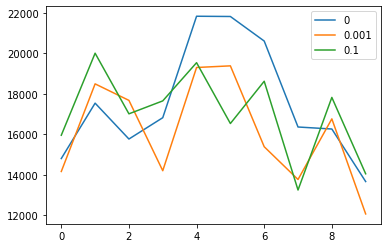

In [69]:
#Loss Scores
for l in loss_3:
    sns.lineplot(x=np.arange(0, len(torch.Tensor(l))), y=torch.Tensor(l))
plt.legend(labels=["0", "0.001", "0.1"])

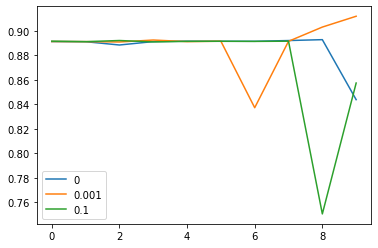

In [70]:
#F1 Scores
for f in f1_3:
    sns.lineplot(x=np.arange(0, len(torch.Tensor(f))), y=torch.Tensor(f))    
plt.legend(labels=["0", "0.001", "0.1"])

Step 4

In a few sentences, describe what you see: What effect does the choice in optimizer have on the convergence speed and overall
model performance?

(answer): The code below reveals a consistently higher loss rate RMSprop over AdamW, but AdamW reported higher F1 scores. The  loss rates appear to be misleading as they don't really change over time. AdamW's higher F1 scores indicate better model performance

In [82]:
loss_4 = []
f1_4   = []

#Training Data
optimizers = [
    optim.RMSprop(model.parameters(), lr=0.05), 
    optim.AdamW(model.parameters(), lr=0.05)
]

#Training Data
for o in optimizers:
    model = LogisticRegression(input_dim, output_dim)
    criterion = nn.BCELoss()
    optimizer = o
    
    sublist_loss = []
    sublist_f1   = []
    
    running_loss = 0.0

    for epoch in range(1):
        for i in tqdm(range(30000)): #len(sparse_tensor_train)
            model.train()
            optimizer.zero_grad()
            predictions = model(sparse_tensor_train[i]).squeeze()
            loss = criterion(predictions, y_train[i])
            running_loss += loss.detach()
            loss.backward()
            optimizer.step()
    
            if i % 1000 == 999:        
                sublist_loss.append(running_loss)
                running_loss = 0.0
                model.eval()
                predictions = model(sparse_tensor_dev).squeeze()
                sublist_f1.append(F1_score(y_dev, predictions))
    
    loss_4.append(sublist_loss)
    f1_4.append(sublist_f1)

100%|██████████| 30000/30000 [15:17<00:00, 32.71it/s]


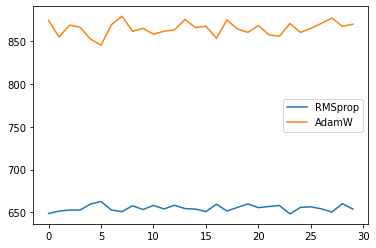

In [83]:
#Loss Scores
for l in loss_4:
    sns.lineplot(x=np.arange(0, len(torch.Tensor(l))), y=torch.Tensor(l))
plt.legend(labels=["RMSprop", "AdamW"])

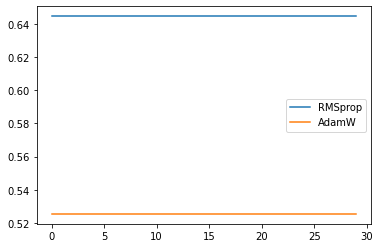

In [84]:
#F1 Scores
for f in f1_4:
    sns.lineplot(x=np.arange(0, len(torch.Tensor(f))), y=torch.Tensor(f))    
plt.legend(labels=["RMSprop", "AdamW"])

Step 7

Training the best model and preparing the results for the Kaggle submission

In [47]:
test = pd.read_csv('test.csv')

In [48]:
model = LogisticRegression(input_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

#Training Data
for epoch in range(3):
    print(f"Epoch: {epoch + 1}")
        
    for i in tqdm(range(len(sparse_tensor_train))):
        optimizer.zero_grad()
        predictions = model(sparse_tensor_train[i]).squeeze()
        loss = criterion(predictions, y_train[i])
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 999:
            print(loss)
           
test_predictions = model(sparse_tensor_test).squeeze()

  0%|          | 1/59999 [00:00<1:49:34,  9.13it/s]

Epoch: 1


  2%|▏         | 1003/59999 [00:23<23:19, 42.17it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


  3%|▎         | 2006/59999 [00:46<23:55, 40.41it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


  5%|▌         | 3005/59999 [01:09<24:07, 39.37it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


  7%|▋         | 4009/59999 [01:37<26:55, 34.66it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


  8%|▊         | 5005/59999 [02:04<23:10, 39.54it/s]

tensor(100., grad_fn=<BinaryCrossEntropyBackward0>)


 10%|█         | 6008/59999 [02:29<20:49, 43.20it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 12%|█▏        | 7006/59999 [02:53<24:34, 35.95it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 13%|█▎        | 8004/59999 [03:19<22:50, 37.95it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 15%|█▌        | 9008/59999 [03:45<20:25, 41.62it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 17%|█▋        | 10007/59999 [04:11<21:25, 38.89it/s]

tensor(100., grad_fn=<BinaryCrossEntropyBackward0>)


 18%|█▊        | 11003/59999 [04:36<20:44, 39.35it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 20%|██        | 12004/59999 [05:01<20:49, 38.42it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 22%|██▏       | 13005/59999 [05:27<20:21, 38.46it/s]

tensor(100., grad_fn=<BinaryCrossEntropyBackward0>)


 23%|██▎       | 14004/59999 [05:52<18:33, 41.32it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 25%|██▌       | 15005/59999 [06:18<20:46, 36.08it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 27%|██▋       | 16008/59999 [06:43<16:15, 45.08it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 28%|██▊       | 17009/59999 [07:08<15:53, 45.09it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 30%|███       | 18003/59999 [07:33<22:16, 31.43it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 32%|███▏      | 19010/59999 [07:56<13:28, 50.71it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 33%|███▎      | 20006/59999 [08:21<15:49, 42.13it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 35%|███▌      | 21009/59999 [08:45<15:43, 41.31it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 37%|███▋      | 22005/59999 [09:10<16:48, 37.67it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 38%|███▊      | 23003/59999 [09:35<18:21, 33.58it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 40%|████      | 24003/59999 [09:59<18:02, 33.27it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 42%|████▏     | 25007/59999 [10:23<12:59, 44.91it/s]

tensor(100., grad_fn=<BinaryCrossEntropyBackward0>)


 43%|████▎     | 26006/59999 [10:46<13:31, 41.88it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 45%|████▌     | 27003/59999 [11:12<15:20, 35.84it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 47%|████▋     | 28005/59999 [11:36<10:46, 49.52it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 48%|████▊     | 29005/59999 [12:01<12:42, 40.65it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 50%|█████     | 30008/59999 [12:25<09:56, 50.30it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 52%|█████▏    | 31002/59999 [12:50<10:58, 44.04it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 53%|█████▎    | 32006/59999 [13:14<11:04, 42.12it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 55%|█████▌    | 33006/59999 [13:39<11:18, 39.78it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 57%|█████▋    | 34008/59999 [14:05<10:16, 42.13it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 58%|█████▊    | 35003/59999 [14:30<09:58, 41.75it/s]

tensor(34.8895, grad_fn=<BinaryCrossEntropyBackward0>)


 60%|██████    | 36004/59999 [14:55<15:57, 25.07it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 62%|██████▏   | 37006/59999 [15:26<11:26, 33.50it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 63%|██████▎   | 38004/59999 [15:56<15:51, 23.11it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 65%|██████▌   | 39008/59999 [16:25<08:14, 42.42it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 67%|██████▋   | 40007/59999 [16:53<09:34, 34.80it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 68%|██████▊   | 41003/59999 [17:24<09:31, 33.23it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 70%|███████   | 42006/59999 [17:55<07:38, 39.27it/s]

tensor(14.1449, grad_fn=<BinaryCrossEntropyBackward0>)


 72%|███████▏  | 43004/59999 [18:20<07:56, 35.66it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 73%|███████▎  | 44005/59999 [18:45<07:14, 36.81it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 75%|███████▌  | 45003/59999 [19:11<07:38, 32.72it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 77%|███████▋  | 46008/59999 [19:36<05:50, 39.92it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 78%|███████▊  | 47008/59999 [20:04<05:06, 42.36it/s]

tensor(100., grad_fn=<BinaryCrossEntropyBackward0>)


 80%|████████  | 48004/59999 [20:31<06:20, 31.49it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 82%|████████▏ | 49005/59999 [20:57<05:17, 34.64it/s]

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


 83%|████████▎ | 49543/59999 [21:21<04:30, 38.67it/s]


KeyboardInterrupt: 

In [ ]:
test_predictions

In [ ]:
z = test_predictions

In [ ]:
test['outcome'] = np.round(np.array(z.detach()))
test['party_affiliation'] = pd.Series(np.where(test['outcome'].values == 1, 'Democratic Party', 'Republican Party'))

pytorch_submission_df = test[['uid_email', 'party_affiliation']]
pytorch_submission_df

In [ ]:
pytorch_submission_df.to_csv('pytorch_logit_submission.csv', index=False)